In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt

import astropy.units as u

import emcee

from measure_extinction.stardata import StarData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from helpers import (plot_data_model, plot_data_model, comp_ext, plot_ext, 
                     get_fit_params, get_full_params, get_fit_params_g23only, get_full_params_g23only)          

## Info about the specific star and data to fit

Specify the location of the model and observed data

In [2]:
data_file_path = "/home/kgordon/Python/extstar_data/DAT_files/"
model_file_path = "/home/kgordon/Python/extstar_data/"

Define star specific parameters

In [3]:
starname = "2massj150958"
fstarname = f"{starname}.dat"
velocity = 0.0   # assumption
relband = 0.55 * u.micron  # needed for dust extinction

# sptype and Teff, logg, from from Wei, C et al. (master thesis)
sptype = "B5Ia"
teff = 15000.0
teff_unc = 2000.0
logt = np.log10(teff)
logt_unc = 0.5 * (np.log10(teff + teff_unc) - np.log10(teff - teff_unc))
print(logt, logt_unc)
logg = 2.4
logg_unc = 0.1

# parameter names
pnames = ["logT","logg", "logZ", "Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
# logZ and HI_mw not fit as sources in MW so HI_gal = HI_MW
pnames_fit = ["logT","logg", "Av","Rv"]
fitparamsfunc = get_fit_params_g23only
fullparamsfunc = get_full_params_g23only
fit_range = "g23"

# initial starting position
params = [logt, logg, 0.0, 5.0, 3.1, 0.7, 3.23, 0.41, 4.59, 0.95, 20.5, 17.0]

# add Gaussian priors based on prior knowledge
#ppriors = None
ppriors = {}
ppriors["logT"] = (logt, logt_unc)
ppriors["logg"] = (logg, logg_unc)

4.176091259055681 0.05825278453571858


Give the fitting parameters

In [4]:
# emcee
nsteps = 5000

Read in the star data

In [5]:
# get the observed reddened star data
reddened_star = StarData(fstarname, path=f"{data_file_path}")
band_names = reddened_star.data["BAND"].get_band_names()
for ckey in list(reddened_star.data.keys()):
    if ckey not in ["BAND", "STIS_Opt"]:
        del reddened_star.data[ckey]
data_names = reddened_star.data.keys()
print(data_names)

dict_keys(['BAND', 'STIS_Opt'])


Create the weight arrays based on the observed uncertainties and exclude regions that have known lines not fit by the models (ISM gas, etc.).

In [6]:
# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
] / u.micron

weights = {}
for cspec in data_names:
    weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
    gvals = reddened_star.data[cspec].npts > 0

    weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

    x = 1.0 / reddened_star.data[cspec].waves
    for cexreg in ex_regions:
        weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

Get the model data

In [7]:
tlusty_models_fullpath = glob.glob(f"{model_file_path}/Models/tlusty_*v10.dat")
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path=f"{model_file_path}/Models/",
    band_names=band_names,
    spectra_names=data_names,
)

Setup the fit parameters

In [8]:
# not all these parameters are being fit
#   not fitting for met, log(HI) MW foreground
plimits = [
        [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
        [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
        [0.0, 0.0], # met
        [0.0, 10.0],   # Av
        [2.31, 5.59],   # Rv
        [-0.1, 5.0],  # C2
        [-1.0, 6.0],   # C3
        [-0.5, 1.5],   # C4
        [4.5, 4.9],   # xo
        [0.6, 1.5],   # gamma
        [18.0, 24.0], # log(HI) internal to galaxy
        [17.0, 22.0], # log(HI) MW foreground
    ]

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [9]:
fitinfo = FitInfo(
    pnames,
    plimits,
    weights,
    parameter_priors=ppriors,
    stellar_velocity=velocity,
)

In [10]:
# check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
fitinfo.check_param_limits(params)
print(fitinfo.lnlike(params, reddened_star, modinfo))
print(fitinfo.lnprior(params))
print(fitinfo.lnprob(params, reddened_star, modinfo, fitinfo))

-4967096.178565078
0.0
-4967096.178565078


## Do the fitting to find the best fit (using a minimizer)

In [11]:
# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def nll(params, *args):
    full_params = fullparamsfunc(params)
    return -fitinfo.lnprob(full_params, *args, fit_range=fit_range)

init_fit_params = fitparamsfunc(params)

# run the fit
result = op.minimize(
    nll, init_fit_params, method="Nelder-Mead", options={"maxiter": 10000}, 
    args=(reddened_star, modinfo, fitinfo)
)

# check the fit output
print(result["message"])

Optimization terminated successfully.


In [12]:
# print results
params_best = result["x"]

# print the best fit
for k, val in enumerate(params_best):
    print(f"{val} # {pnames_fit[k]}")

4.254742022721382 # logT
2.3676142166359124 # logg
4.452917100001168 # Av
2.8319443032750247 # Rv


Plot the spectra with the best fit model

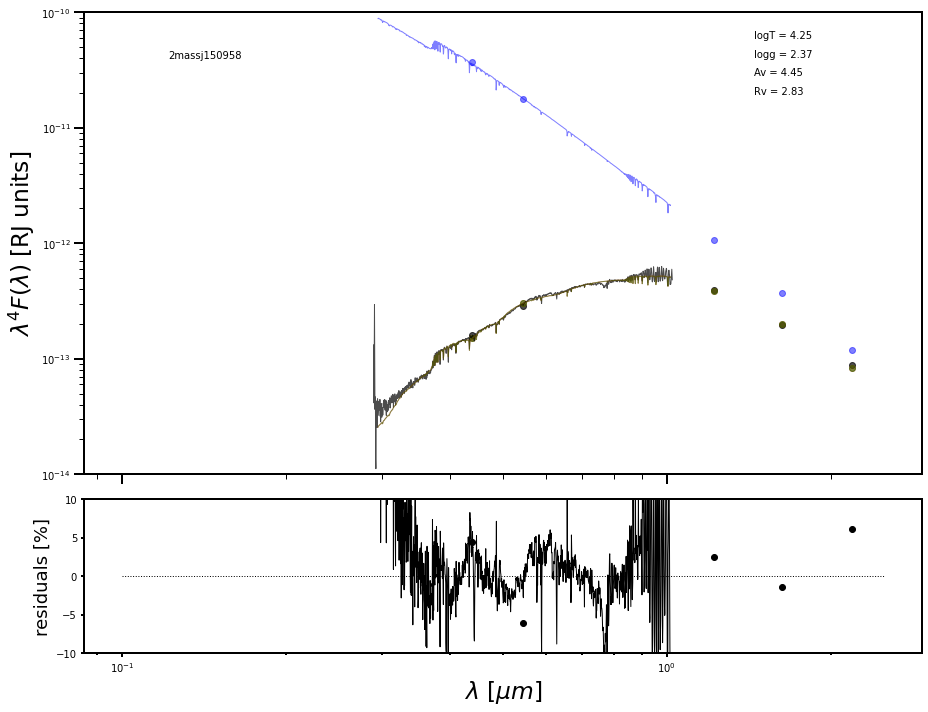

In [13]:
# plot optimizer/minimizer best fit
plot_data_model(reddened_star, weights, modinfo, params_best, pnames_fit, starname, velocity,
                prange=[1e-14, 1e-10], fullparamsfunc=fullparamsfunc, fit_range=fit_range)

###### Run emcee MCMC sampler to define uncertainties (bonus section)

In [14]:
p0 = params_best
ndim = len(p0)

def lnprob_mcmc(params, *args):
    full_params = fullparamsfunc(params)
    return fitinfo.lnprob(full_params, *args, fit_range=fit_range)

nwalkers = 2 * ndim

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob_mcmc, args=(reddened_star, modinfo, fitinfo)
)

# do the full sampling
pos, prob, state = sampler.run_mcmc(p, nsteps, progress=True)

  0%|                                                                        | 0/5000 [00:00<?, ?it/s]/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████| 5000/5000 [46:20<00:00,  1.80it/s]


In [15]:
# create the samples variable for later use
flat_samples = sampler.get_chain(discard=int(0.1*nsteps), flat=True)

# get the best fit values
params_best = get_best_fit_params(sampler)

def get_percentile_params(samples):
    """
    Determine the 50p plus/minus 33p vlaues
    """

    per_params = map(
        lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
        zip(*np.percentile(samples, [16, 50, 84], axis=0)),
    )

    return per_params

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(flat_samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
n_params = len(params_best)
params_p50 = np.zeros(n_params)
params_unc = np.zeros(n_params)
print("best p50 -munc +unc # paramname")
for k, val in enumerate(params_per):
    params_p50[k] = val[0]
    params_unc[k] = 0.5 * (val[1] + val[2])
    print(f"{params_best[k]:.3f} {val[0]:.3f} {val[1]:.3f} {val[2]:.3f} # {pnames_fit[k]}")

best p50 -munc +unc # paramname
4.241 4.241 0.001 0.000 # logT
2.169 2.169 0.003 0.000 # logg
4.415 4.415 0.004 0.000 # Av
2.828 2.828 0.002 0.000 # Rv


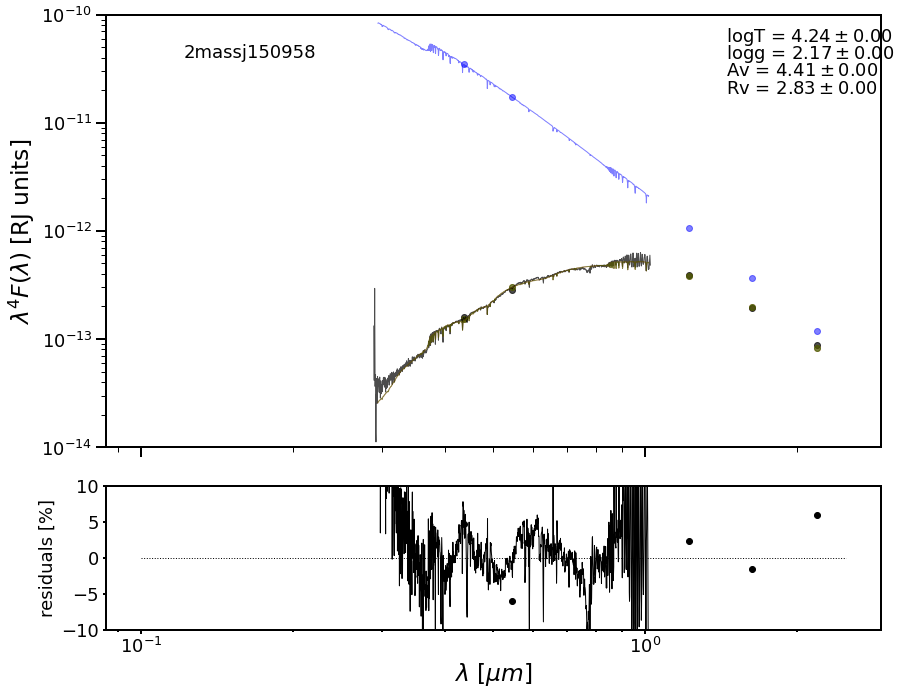

In [16]:
plot_data_model(reddened_star, weights, modinfo, params_best, pnames_fit, starname, velocity, 
                params_unc=params_unc, prange=[1e-14, 1e-10], fullparamsfunc=fullparamsfunc, fit_range=fit_range)

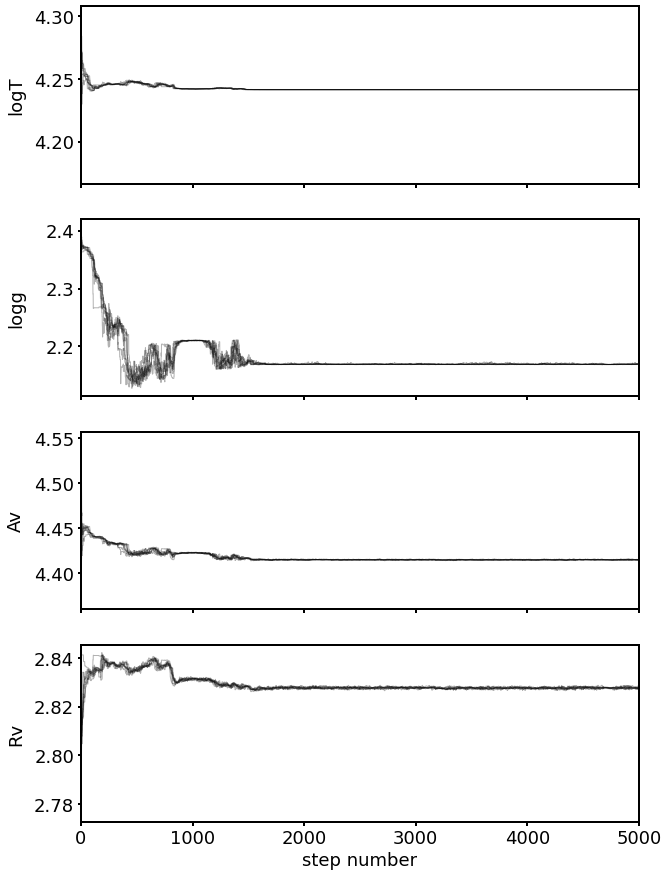

In [17]:
nparam = len(params_best)
fig, axes = plt.subplots(nparam, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
labels = pnames_fit
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

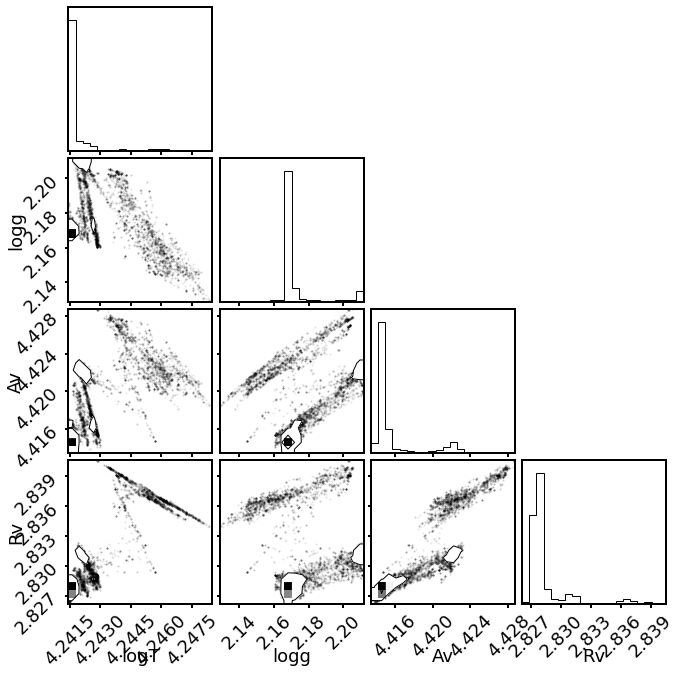

In [18]:
import corner

fig = corner.corner(flat_samples, labels=labels)

## Compute extinction and plot

Calculate the E(B-V) = E(44 - 55), A(V), and R(V) from the computed extinction curve

(1.4924764902910546, 0.006279637626523864)
(4.443350670951763, 0.01692643663601483)
(2.977166273543944, 0.016897803358686632)


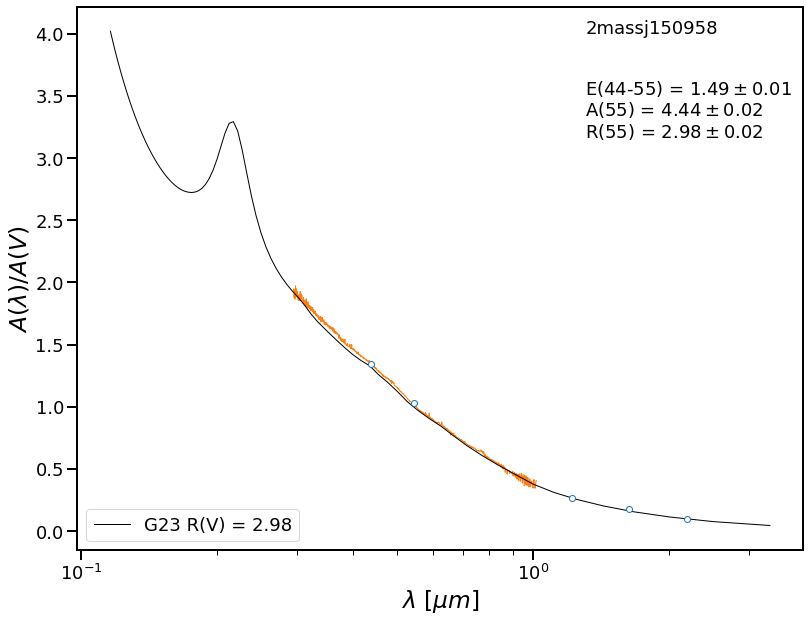

In [19]:
extdata = comp_ext(modinfo, fullparamsfunc(params_best), velocity, reddened_star, relband, starname)
plot_ext(extdata, starname)